## 1. 读取数据

In [1]:
# package
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from statsmodels.stats.weightstats import ttest_ind as ttest
from statsmodels.stats.multitest import multipletests as multipletests
import scipy.cluster.hierarchy as sch
from collections import defaultdict
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
# file
file_gene_expression_array = "rawData/TCGA.COADREAD.sampleMap_AgilentG4502A_07_3.gz"
file_gene_expression_RNAseq = "rawData/TCGA.COADREAD.sampleMap_HiSeqV2.gz"
file_exon_expression_RNAseq = "rawData/TCGA.COADREAD.sampleMap_HiSeqV2_PANCAN.gz"
file_protein_expression = "rawData/TCGA.COADREAD.sampleMap_RPPA_RBN.gz"
file_survial = "rawData/TCGA.COADREAD_survival.txt"
file_clinical = "rawData/TCGA.COADREAD.sampleMap_COADREAD_clinicalMatrix.txt"
# read
data_gene_expression_array = pd.read_csv(file_gene_expression_array,sep='\t' ,compression='gzip', low_memory=False)
data_gene_expression_RNAseq = pd.read_csv(file_gene_expression_RNAseq, sep='\t', compression='gzip', low_memory=False)
data_exon_expression_RNAseq = pd.read_csv(file_exon_expression_RNAseq, sep='\t', compression='gzip', low_memory=False)
dat_protein_expression = pd.read_csv(file_protein_expression, sep='\t', compression='gzip', low_memory=False)
dat_survial = pd.read_csv(file_survial, sep='\t', low_memory=False)
dat_clinical = pd.read_csv(file_clinical, sep='\t', low_memory=False)

## 2. 差异表达分析

In [2]:
def diffexp(sample_Normal, sample_Tumor, data, **p):
    Normal_bool = [i in sample_Normal  for i in data.columns]
    Tumor_bool = [i in sample_Tumor for i in data.columns]
    # 计算FDR
    pval = data.apply(lambda x:ttest(x[Tumor_bool], x[Normal_bool])[1],axis=1)
    pval = pval.fillna(1) #na替换为1 合适么？
    fdr  = multipletests(pval, method='fdr_bh')[1]
    fdrlog = -np.log10(fdr)
    # 计算fold change
    Tumor_mean = data.loc[:,Tumor_bool].mean(axis=1)
    Normal_mean = data.loc[:,Normal_bool].mean(axis=1)
    fd = Tumor_mean/ Normal_mean
    fdlog = np.log(fd)
    #做图
    c1 = fdlog<-2
    c2 = (fdlog>=-2) & (fdlog<=2)
    c3 = fdlog>2
    ax = p.get('ax')
    title = p.get('title')
    ax.plot(
        fdlog[c1], fdrlog[c1], 'r.',
        fdlog[c2], fdrlog[c2], 'g.',
        fdlog[c3], fdrlog[c3], 'b.',
        )
    ax.set_title(title)
    ax.set_xlabel("log(FC)")
    ax.set_ylabel("-log(FDR)")
    ax.legend(['Down','other','Up'])
    # 输出基因名
    gene_down = list(data_gene_expression_array['sample'][fdlog<-2])
    gene_up = list(data_gene_expression_array['sample'][fdlog>2])
    return gene_down, gene_up
set(dat_clinical["AWG_cancer_type_Oct62011"]) #查看标本分类: {'Colon', 'Rectum', nan}
smaple_Colon = list(dat_clinical[dat_clinical["AWG_cancer_type_Oct62011"]=="Colon"]["sampleID"])
smaple_Rectum = list(dat_clinical[dat_clinical["AWG_cancer_type_Oct62011"]=="Rectum"]["sampleID"])
sample_Normal = list(dat_clinical[dat_clinical["AWG_cancer_type_Oct62011"].isna()]["sampleID"])
sample_Tumor = smaple_Colon+smaple_Rectum

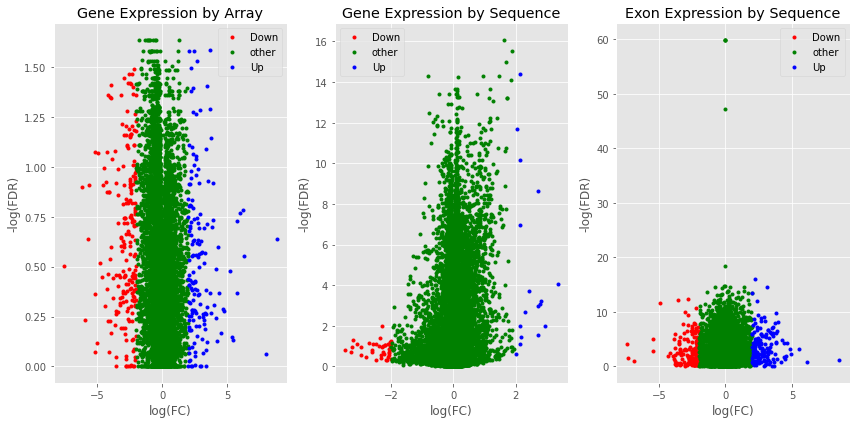

In [3]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
p = {'ax':axs[0], 'title':'Gene Expression by Array'}
gene_down_array, gene_up_array = diffexp(sample_Normal, sample_Tumor, data_gene_expression_array, **p)
p = {'ax':axs[1], 'title':'Gene Expression by Sequence'}
gene_down_seq, gene_up_seq = diffexp(sample_Normal, sample_Tumor, data_gene_expression_RNAseq, **p)
p = {'ax':axs[2], 'title':'Exon Expression by Sequence'}
exon_down_seq, exon_up_seq = diffexp(sample_Normal, sample_Tumor, data_exon_expression_RNAseq,**p)
fig.tight_layout()

## 3. 免疫相关差异基因

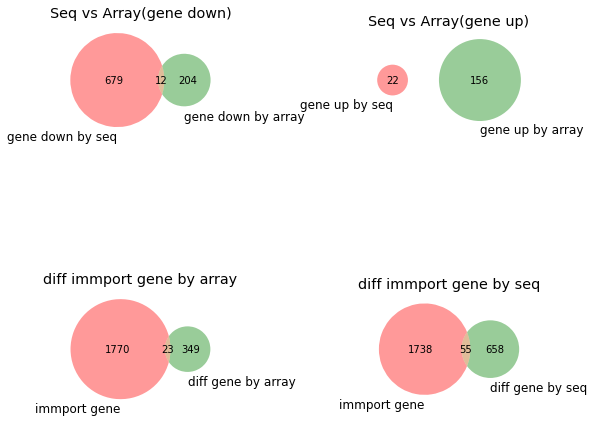

In [4]:
data_immport = pd.read_csv("rawData/GeneListImmPort.txt", sep='\t')
gene_immport = set(data_immport['Symbol'])
figure, axes = plt.subplots(2, 2, figsize=(8,8))
venn2([set(gene_down_seq), set(gene_down_array)],["gene down by seq", "gene down by array"],ax=axes[0][0])
axes[0][0].set_title("Seq vs Array(gene down)")
venn2([set(gene_up_seq), set(gene_up_array)],["gene up by seq", "gene up by array"],ax=axes[0][1])
axes[0][1].set_title("Seq vs Array(gene up)")
venn2([set(gene_immport), set(gene_down_array+gene_up_array)],["immport gene", "diff gene by array"],ax=axes[1][0])
axes[1][0].set_title("diff immport gene by array")
venn2([set(gene_immport), set(gene_down_seq + gene_up_seq)],["immport gene", "diff gene by seq"],ax=axes[1][1])
axes[1][1].set_title("diff immport gene by seq")
plt.tight_layout()
diff_ImmPort_gene_array = gene_immport.intersection(set(gene_up_array+gene_down_array))
diff_ImmPort_gene_seq = gene_immport.intersection(set(gene_up_seq+gene_down_seq))

## 4. 聚类分析

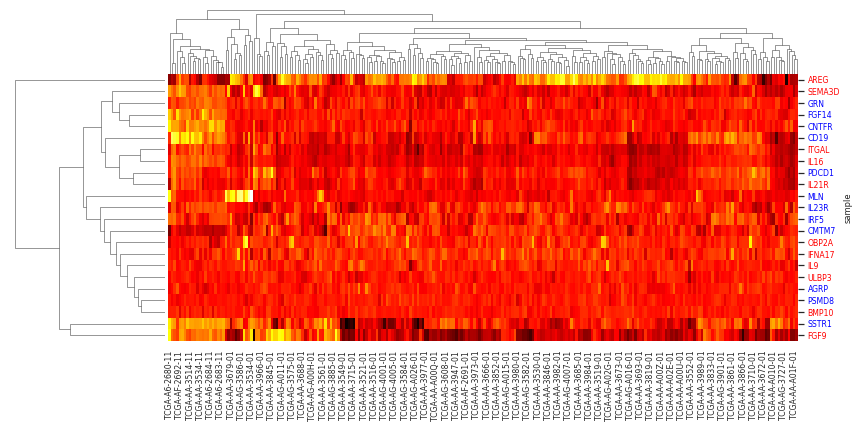

In [5]:
sns.set(font_scale=0.7)
data_diffexp_immport = data_gene_expression_array[data_gene_expression_array["sample"].isin(diff_ImmPort_gene_array)]
data_diffexp_immport_gene = data_diffexp_immport.iloc[:,0]
data_diffexp_immport_value = data_diffexp_immport.iloc[:,1:]
data_diffexp_immport_value.index = data_diffexp_immport_gene
data_diffexp_immport_value.fillna(0.5, inplace=True)
g = sns.clustermap(data_diffexp_immport_value,cbar_pos=None, cmap="hot",  figsize=(12,6), method='complete')
for l in g.ax_heatmap.axes.get_yticklabels():
    if l.get_text() in gene_down_array:
        l.set_color('blue')
    if l.get_text() in gene_up_array:
        l.set_color('red')

{1, 2, 3, 4, 5}

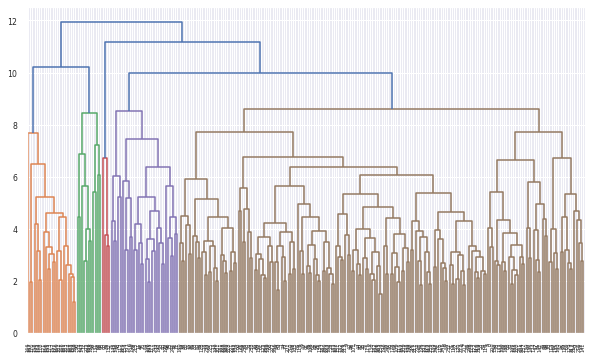

In [6]:
d = sch.distance.pdist(data_diffexp_immport_value.T)
L = sch.linkage(d, method='complete')
colorCutoff = 0.75*d.max()
fig = plt.figure(figsize=(10,6))
sch.dendrogram(L,color_threshold=colorCutoff)
clusters = sch.fcluster(L, colorCutoff, 'distance')
set(clusters)

## 5. 生存分析

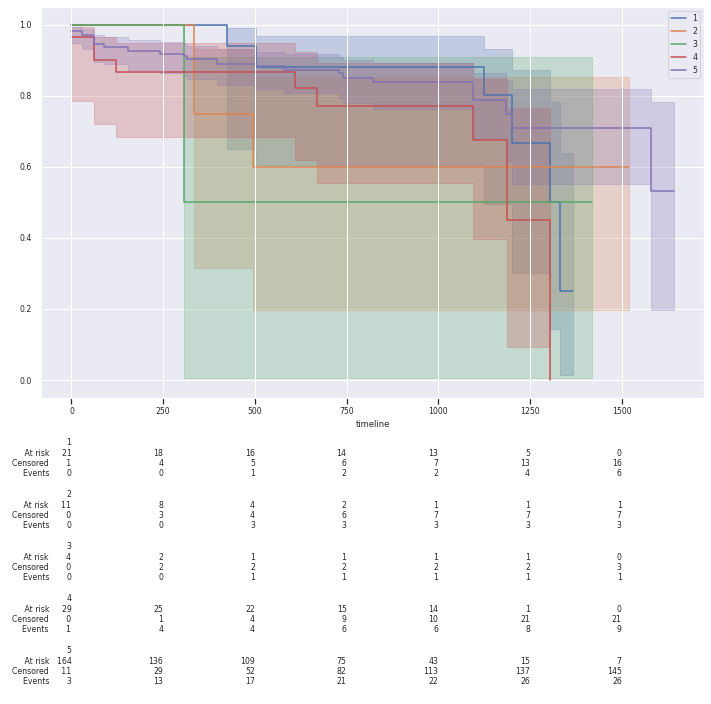

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
kmfSet  = []
for i in set(clusters):
    kmf = KaplanMeierFitter()
    s = data_diffexp_immport_value.columns[clusters==i]
    t = dat_survial[dat_survial['sample'].isin(s)]
    t = t[~t['OS'].isna()][~t['OS.time'].isna()]
    ax = kmf.fit(t['OS.time'],t['OS'], label=i).plot_survival_function(ax=ax)
    kmfSet.append(kmf)
add_at_risk_counts(*kmfSet,ax=ax)
plt.tight_layout()